*Start by running helpers/ scripts first, then run this notebook*

In [54]:
# !pip install sentence_transformers xlrd


JOKES_SEP = '\n\n\n'


In [55]:
with open('data/jokes.txt', 'r') as f:
    text = f.read()
jokes = text.split(JOKES_SEP)[:100] # 101 element is '\n'
jokes[0]

"Why are there so many Jones's in the phone book?\nBecause they all have phones."

## Extract embeddings

In [56]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-cased')

jokes_embeddings = model.encode(jokes)
jokes_embeddings.shape

No sentence-transformers model found with name bert-base-cased. Creating a new one with mean pooling.
/home/jakubner/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


(100, 768)

In [57]:
jokes_embeddings[0].shape

(768,)

In [58]:
import numpy as np
import pandas as pd


def load_ratings(filename) -> np.ndarray:
    """ratings: N x 101"""
    ratings = pd.read_excel(filename, header=None)
    return ratings.to_numpy()

ratings_data = np.concatenate([
    load_ratings('raw_data/jester-data-1.xls'), 
    load_ratings('raw_data/jester-data-2.xls'),
    load_ratings('raw_data/jester-data-3.xls'),
    ], axis=0)

In [59]:
ratings = ratings_data[: , 1:]

# if value is 99, it means that user didn't rate the joke
print(f'{ratings[ratings == 99].shape[0]} null values') 
ratings[ratings == 99] = np.nan

ratings_means = np.nanmean(ratings, axis=0)
ratings_means.max(), ratings_means.min()

3205740 null values


(3.3625929395733083, -3.7045409911996297)

In [60]:
ratings.shape

(73421, 100)

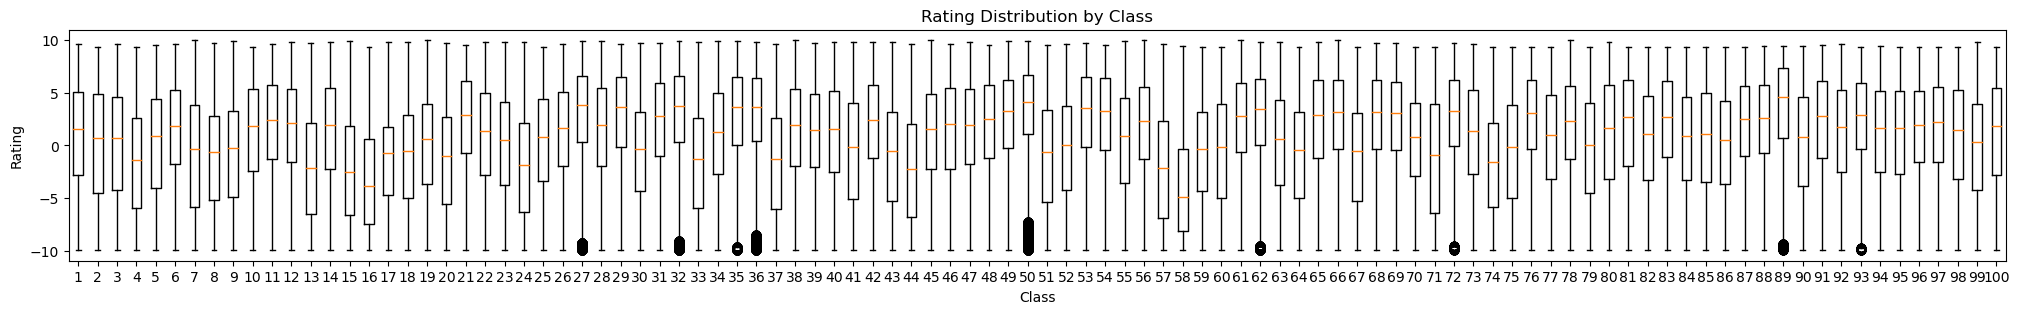

In [61]:
# plot relation between joke number and its rating
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 3))

bool_mask = ~np.isnan(ratings)
plotting_data = [d[m] for d, m in zip(ratings.T, bool_mask.T)]

plt.boxplot(plotting_data)
plt.title('Rating Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Rating')
plt.show()

In [62]:
# TODO: set outliers to mean value


In [65]:
LEARNING_RATE = 'constant'
ACTIVATION = 'relu'
ALPHA = 0.0
SOLVER = 'sgd'

EPOCHS = 1

In [66]:

from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split

# train & test 0.9, validation 0.1
X, X_validation, y, y_validation = train_test_split(jokes_embeddings, ratings_means, test_size=0.1, random_state=42)

print("Training & Testing set shape:", X.shape, y.shape)
print("Validation set shape:", X_validation.shape, y_validation.shape)

model = MLPRegressor(
    hidden_layer_sizes=(100, 786),
    learning_rate=LEARNING_RATE,
    activation=ACTIVATION,
    solver=SOLVER,
    alpha=ALPHA,
)

Training & Testing set shape: (90, 768) (90,)
Validation set shape: (10, 768) (10,)


In [70]:
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold


test_errors = []
validation_errors = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for i in range(EPOCHS):
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        test_errors.append(np.mean((y_pred - y_test) ** 2))

        y_pred = model.predict(X_validation)
        validation_errors.append(np.mean((y_pred - y_validation) ** 2))

        print(f'Epoch: {i}, Test error: {test_errors[-1]}, Validation error: {validation_errors[-1]}')
    

/home/jakubner/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch: 0, Test error: 2.9774953156607875, Validation error: 1.16115607174708


/home/jakubner/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch: 0, Test error: 3.176982220981772, Validation error: 1.4695894480743348


/home/jakubner/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch: 0, Test error: 2.576577955167731, Validation error: 1.260860506289218


/home/jakubner/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch: 0, Test error: 2.897871257085709, Validation error: 1.3352115732637153
Epoch: 0, Test error: 1.9647350542506885, Validation error: 1.6342885585892084


/home/jakubner/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
x_train.shape, y_train.shape

((70, 768), (21,))